# Test the two-line CLEDB inversion on synthetic CLE data.

In [1]:
## the script version "test_2line.py" is generated by exporting this notebook via file -> export as -> executable script.
## Do not directly edit that version!

In [2]:
## Needed modules
import pickle                ## CLE synthetic observation data cube is saved in the pickle format.
import importlib             ## reloads imports (python default settings will not reload small changes).

from numba.typed import List ## Most numba functions are loaded by the CLEDB modules; non-reflected lists are needed to create a list of 2 bservation arrays

## Inversion Constants and control parameter imports.
## symbolic links pointing to the root directory containing the files are used. Pythondoes not allow relative upstream references anymore
import constants as consts
import ctrlparams 
params=ctrlparams.ctrlparams()    ## just a shorter label

### 1. Import the synthetic CLE observation.

In [3]:
## observations of a 3 dipole coronal structure of a Fe XIII combined observation
## sobs1-3 are the independent dipoles
## sobsa is the combined 3 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

with open('obsstokes_3dipole_hires_fullspectra.pkl','rb') as f:
    sobs1,sobs2,sobs3,sobsa,waveA,waveB = pickle.load(f)  
### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
sobs1=sobs1[:,:,::-1,:]   
sobs2=sobs2[:,:,::-1,:]
sobs3=sobs3[:,:,::-1,:]
sobsa=sobsa[:,:,::-1,:]
#waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
#waveB=waveB[::-1]

In [4]:
## observations of sheetlos coronal structure of a Fe XIII combined observation
## sobsa is the combined 5 dipole output
## waveA and waveB are the wavelength arrays for the two Fe XIII lines

# with open('obsstokes_sheetslos_hires_fullspectra.pkl','rb') as f:
#    sobsa,waveA,waveB = pickle.load(f)  
### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
# sobsa=sobsa[:,:,::-1,:]
# waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
# waveB=waveB[::-1]

In [5]:
# load the fake observation muram data.             
# FE XIII 1074+1079

# with open('obsstokes_avg_muram3.pkl','rb') as f:
#     sobsa = pickle.load(f) 
# sobsa=sobsa[0]  

## muram data too big to include as test data!!!!

### 2. Test the CLEDB_PREPINV module with synthetic data. 

##### Remember to set your personal options and database paths in the ctrlparams class (in the parent directory) before continuing.

In [6]:
import CLEDB_PREPINV.CLEDB_PREPINV as prepinv  ##imports from the CLEDB_PREPINV subdirectory

In [7]:
## arrange the two observation "files" in a simple list;
## un-necesary step given the shape of sobs array, but it mimicks a file/header structure.

## set a proper numba typed list
sobs_lst=[sobsa[:,:,:,0:4],sobsa[:,:,:,4:8]]  ## standard python lists will be deprecated ; they do not work well with numba
sobs_in = List()                              ## this is the List object implemented by numba; It utilizes memory in a column-like fashion.
[sobs_in.append(x) for x in sobs_lst]         ## Numba developers claim that it is a significantly faster performing object

[None, None]

##### preprocess the observation "files"

In [8]:
#importlib.reload(prepinv)       ## If module is modified, reload the contents
sobs_tot,yobs,rms,background,keyvals,sobs_totrot,aobs=prepinv.sobs_preprocess(sobs_in,params)

------------------------------------
--------OBS PROCESSING START--------
------------------------------------
We are inverting observations of 2 coronal line(s) 
Line 1: Fe XIII 1074.7nm
Line 2: Fe XIII 1079.8nm
------------------------------------
-----OBS PREPROCESS FINALIZED-------
------------------------------------


In [9]:
## select and pre-read the database files based on the observation preprocessing
## At this point, the database should be generated and properly linked.

#importlib.reload(prepinv)       ## If module is modified, reload the contents
db_enc,database,dbhdr=prepinv.sdb_preprocess(yobs,keyvals,params)
## Warning, this might be memory consuming; see details in documentation

------------------------------------
----------DB READ START-------------
------------------------------------
CLEDB covers a span of 25 heights between 1.001 - 1.48 Solar radius
Load DB datafiles for 25  heights in memory for 2 line(s).
------------------------------------
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1074/DB0120.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1079/DB0120.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1074/DB0260.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1079/DB0260.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/test_cle_degeneracy/db202_R0500/fe-xiii_1074/DB0480.DAT
INDIVIDUAL DB file location: /home/noxpara/Documents/physics_prog/cle/test_cle_degeneracy/db202

##### At this point all necesary data and required databases are loaded into memory for fast processing

(600, 280)


<Figure size 432x288 with 0 Axes>

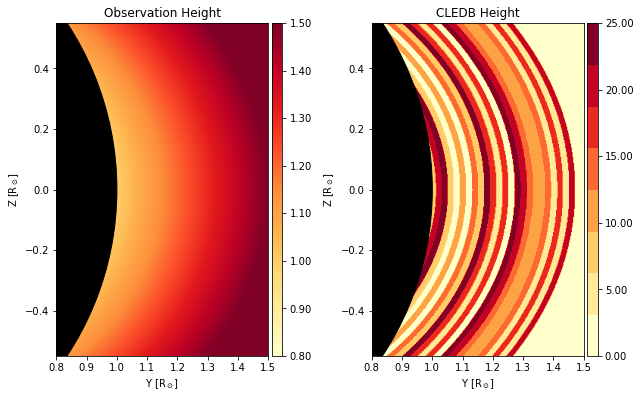

In [11]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
## interactive plotting; use only on local machines if widget is installed
#%matplotlib widget      

# colorbar function to have nice colorbars in figures with title
def colorbar(mappable,*args,**kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax,format='%.2f')
    #cbar.formatter.set_powerlimits((0, 0))
    title= kwargs.get('title', None)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar

plt.figure()
print(yobs.shape)
fig, plots = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
ab=plots[0].imshow(yobs,extent=[0.8,1.5,-0.55,0.55],vmin=0.8,vmax=1.5,cmap='YlOrRd')
plots[0].set_title('Observation Height')
plots[0].set_ylabel('Z [R$_\odot$]')
plots[0].set_xlabel('Y [R$_\odot$]')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[0].add_patch(c1)

cmap = plt.get_cmap('YlOrRd', 8)
ab=plots[1].imshow(db_enc,extent=[0.8,1.5,-0.55,0.55],vmin=0,vmax=25,cmap=cmap)
plots[1].set_title('CLEDB Height')
plots[1].set_ylabel('Z [R$_\odot$]')
plots[1].set_xlabel('Y [R$_\odot$]')
colorbar(ab)
c1 =patches.Circle((0, 0),1, color='black')
plots[1].add_patch(c1)
plt.tight_layout()
plt.savefig(f"/home/noxpara/Desktop/nso_sem_20211130/figs/height_compare.pdf")

### 3. Test the CLEDB_PROC module with the same synthetic data.

In [12]:
import CLEDB_PROC.CLEDB_PROC as procinv

##### Process the spectroscopy outputs

In [13]:
#importlib.reload(procinv)       ## If module is modified, reload the contents 
specout=procinv.spectro_proc(sobs_in,sobs_tot,rms,background,keyvals,consts,params)      ## when storing to disk do an if to reduce dimensions for 1 line cases

--------------------------------------
SPECTRO_PROC: SPECTROSCOPY START
--------------------------------------
SPECTRO_PROC: Executing ext. loop: 0  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 1  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 2  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 3  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 4  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 5  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 6  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 7  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 8  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 9  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 10  of  600  ( 280  calculations / loop)
SPECTRO_PROC: Executing ext. loop: 11  of  600  ( 280  calculat

#####Process the LOS magnetic fields from the first line

In [14]:
#importlib.reload(procinv)       ## If module is modified, reload the contents 
blosout=procinv.blos_proc(sobs_tot[:,:,0:4],rms[:,:,0:4],keyvals,consts,params)

--------------------------------------
--BLOS_PROC: LOS B ESTIMATION START--
--------------------------------------


<ipython-input-14-dd70b06aacf8>:2: RuntimeWarning: invalid value encountered in double_scalars
  blosout=procinv.blos_proc(sobs_tot[:,:,0:4],rms[:,:,0:4],keyvals,consts,params)


--------------------------------------
---BLOS_PROC: LOS B ESTIMATION END----
--------------------------------------


##### Process the full vector magnetic field inversion products

In [15]:
#importlib.reload(procinv)       ## If module is modified, reload the contents
invout,sfound=procinv.cledb_invproc(sobs_totrot,database,db_enc,yobs,aobs,rms,dbhdr,keyvals,params.nsearch,params.maxchisq,params.bcalc,params.reduced,params.verbose)
## WARNING: This step has a significantly long execution time.

--------------------------------------
CLEDB_IVPROC: TWO LINE INVERSION START
--------------------------------------
CLEDB_INVPROC: Executing ext. loop: 0  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 1  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 2  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 3  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 4  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 5  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 6  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 7  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 8  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 9  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 10  of  600  ( 280  calculations / loop)
CLEDB_INVPROC: Executing ext. loop: 11  of  60

## All should be good if we reached this point; all the outputs should be computed and saved in memory.

## 4. OPTIONAL tidbits

In [16]:
##optionally needed libraries and functions

from datetime import datetime
import os
import glob
import numpy as np

from matplotlib import pyplot as plt
## interactive plotting; use only on local machines if widget is installed
#%matplotlib widget       

# colorbar function to have nice colorbars in figures with title
def colorbar(mappable,*args,**kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax,format='%.2f')
    #cbar.formatter.set_powerlimits((0, 0))
    title= kwargs.get('title', None)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar


### 4.a DUMP results (optional)

In [17]:

## Remove old file saves and keep just the last run
lst=glob.glob('./outparams_2line*.pkl')
if len(lst) >0:
    for i in range(len(lst)):
        os.remove(lst[i])
        
## save the last run 
datestamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")        

if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')

with open(f'./testrun_outputs/outparams_2line_{datestamp}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([specout,blosout,invout,sfound], f)

### 4.b PLOT the outputs (optional)

In [19]:
## Plot utils

linen=0                ## choose which line to plot; range is [0:1] for 2 line input

## plot subranges for soome in snapshots
# ## 3dipole
srx1=230
srx2=400
sry1=65
sry2=195
rnge=[0.8,1.5,-1.1,1.1]

##muram      ## muram data not offered as part of the test scripts due to large sizes.
# srx1=0
# srx2=1023
# sry1=0
# sry2=1023
# rnge=[0.989,1.060,-0.071,0.071]


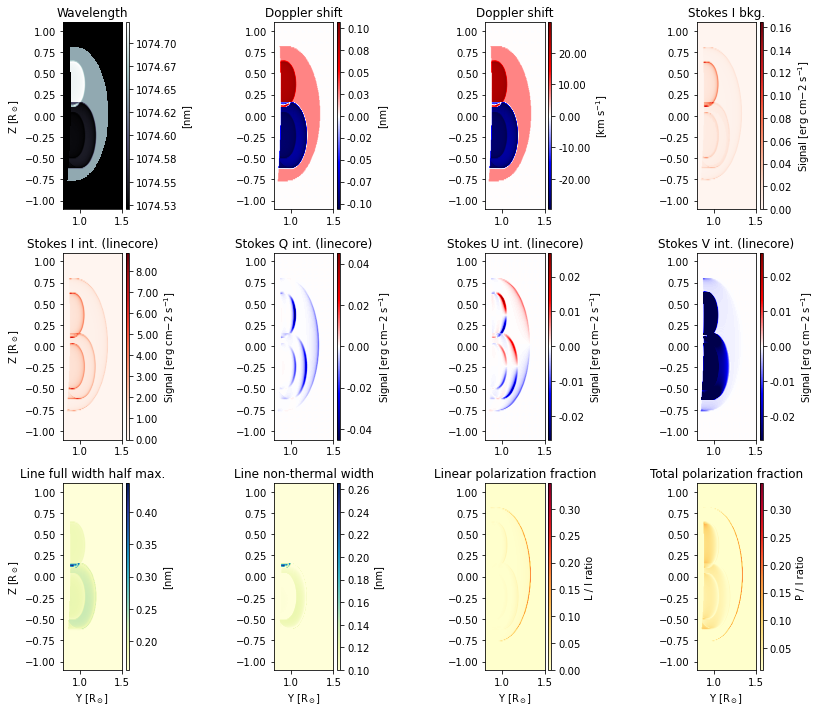

In [20]:
##Plot spectroscopy

fig, plots = plt.subplots(nrows=3, ncols=4, figsize=(12,10))

## remove the 0 values and unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,0], mask=specout[srx1:srx2,sry1:sry2,linen,0]==0)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]>= 3950)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]<= 1070)
vvmin=np.min(mx)
vvmax=np.max(mx)
ab=plots[0,0].imshow(specout[srx1:srx2,sry1:sry2,linen,0],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='bone')
plots[0,0].set_title('Wavelength')
colorbar(ab,title="[nm]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,1], mask=specout[srx1:srx2,sry1:sry2,linen,1]>= 2 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,1]<= -2 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[0,1].imshow(specout[srx1:srx2,sry1:sry2,linen,1],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,1].set_title('Doppler shift')
colorbar(ab,title="[nm]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')
############################################################

## for correctly scaling in doppler scales
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,2], mask=specout[srx1:srx2,sry1:sry2,linen,2]>= 1000 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,2]<= -1000 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
## back to plotting    
ab=plots[0,2].imshow(specout[srx1:srx2,sry1:sry2,linen,2],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[0,2].set_title('Doppler shift')
colorbar(ab,title="[km s$^{-1}$]")
#plots[0,2].set_ylabel('Z [R$_\odot$]')
#plots[0,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[0,3].imshow(specout[srx1:srx2,sry1:sry2,linen,7],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,7]),cmap='Reds')
plots[0,3].set_title('Stokes I bkg.')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[0,3].set_ylabel('Z [R$_\odot$]')
#plots[0,3].set_xlabel('Y [R$_\odot$]')
############################################################

ab=plots[1,0].imshow(specout[srx1:srx2,sry1:sry2,linen,3],extent=rnge,vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,3]),cmap='Reds')
plots[1,0].set_title('Stokes I int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
#plots[1,0].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,4])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,4])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,1].imshow(specout[srx1:srx2,sry1:sry2,linen,4],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,1].set_title('Stokes Q int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,1].set_ylabel('Z [R$_\odot$]')
#plots[1,1].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,2].imshow(specout[srx1:srx2,sry1:sry2,linen,5],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,2].set_title('Stokes U int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,2].set_ylabel('Z [R$_\odot$]')
#plots[1,2].set_xlabel('Y [R$_\odot$]')
############################################################

vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,3].imshow(specout[srx1:srx2,sry1:sry2,linen,6],extent=rnge,vmin=-vr,vmax=vr,cmap='seismic')
plots[1,3].set_title('Stokes V int. (linecore)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
#plots[1,3].set_ylabel('Z [R$_\odot$]')
#plots[1,3].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,8], mask=specout[srx1:srx2,sry1:sry2,linen,8]>= 0.45 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,8]<= 0.01 )
vvmax=np.max(mx)
vvmin=np.min(mx)

ab=plots[2,0].imshow(specout[srx1:srx2,sry1:sry2,linen,8],extent=rnge,vmin=vvmin,vmax=vvmax,cmap='YlGnBu')
plots[2,0].set_title('Line full width half max.')
colorbar(ab,title="[nm]")
plots[2,0].set_ylabel('Z [R$_\odot$]')
plots[2,0].set_xlabel('Y [R$_\odot$]')
############################################################

## remove unreasonable/outlier values.
## PLOT INSIDE THE SAME SUBRANGES AS FULL WIDTHS TO SHOW THAT THEY ARE FRACTIONS.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,9], mask=specout[srx1:srx2,sry1:sry2,linen,9]>= 0.35 )
vvmax=np.nanmax(mx)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,9]<= 0.01 )
vvmin=np.nanmin(mx)

ab=plots[2,1].imshow(specout[srx1:srx2,sry1:sry2,linen,9],extent=rnge,vmin=0.1,vmax=vvmax,cmap='YlGnBu')
plots[2,1].set_title('Line non-thermal width')
colorbar(ab,title="[nm]")
#plots[2,1].set_ylabel('Z [R$_\odot$]')
plots[2,1].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,2].imshow(specout[srx1:srx2,sry1:sry2,linen,10],extent=rnge,vmin=0.00,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,10]),cmap='YlOrRd')
plots[2,2].set_title('Linear polarization fraction')
colorbar(ab,title="L / I ratio")
#plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[2,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[2,3].imshow(specout[srx1:srx2,sry1:sry2,linen,11],extent=rnge,vmin=0.01,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,11]),cmap='YlOrRd')
plots[2,3].set_title('Total polarization fraction')
colorbar(ab,title="P / I ratio")
#plots[2,3].set_ylabel('Z [R$_\odot$]')
plots[2,3].set_xlabel('Y [R$_\odot$]')
############################################################

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/specout_1line_line{linen}_{datestamp}.pdf")

<ipython-input-21-d047bd9afb86>:32: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")
<ipython-input-21-d047bd9afb86>:32: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")
/home/noxpara/anaconda3/envs/CLEDBenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


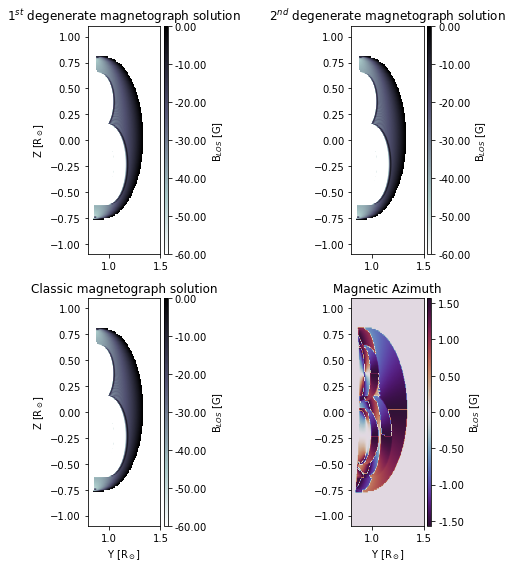

In [21]:
## plot 1-line BLOS

fig, plots = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ab=plots[0,0].imshow(blosout[srx1:srx2,sry1:sry2,0]*1e10,extent=rnge,cmap='bone_r',vmin=-60,vmax=0)
plots[0,0].set_title('1$^{st}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')

ab=plots[0,1].imshow(blosout[srx1:srx2,sry1:sry2,1]*1e10,extent=rnge,cmap='bone_r',vmin=-60,vmax=0)
plots[0,1].set_title('2$^{nd}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')

ab=plots[1,0].imshow(blosout[srx1:srx2,sry1:sry2,2]*1e10,extent=rnge,cmap='bone_r',vmin=-60,vmax=0)
plots[1,0].set_title('Classic magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
plots[1,0].set_xlabel('Y [R$_\odot$]')

ab=plots[1,1].imshow(blosout[srx1:srx2,sry1:sry2,3],extent=rnge,cmap='twilight_shifted')
plots[1,1].set_title('Magnetic Azimuth')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[1,1].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")

<ipython-input-22-f0de07890f0f>:7: RuntimeWarning: invalid value encountered in log10
  ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,cmap='Set1')#,vmin=1e6,vmax=11e6)


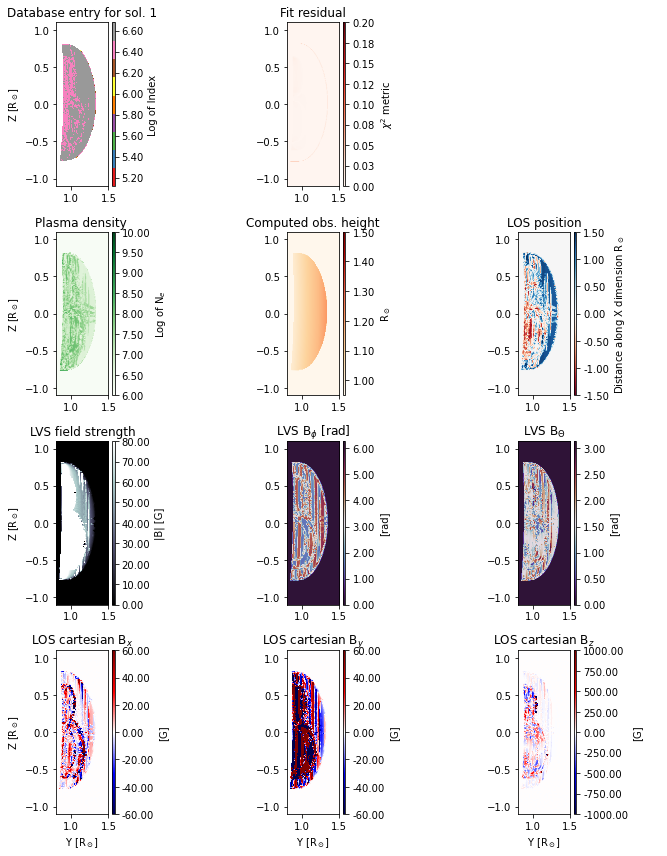

In [22]:
## Plot magnetic inversion

soln=1    ## selects the colution to plot < nsearch

fig, plots = plt.subplots(nrows=4, ncols=3, figsize=(10,12))

ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,cmap='Set1')#,vmin=1e6,vmax=11e6)
plots[0,0].set_title(f'Database entry for sol. {soln}')
colorbar(ab, title='Log of Index')
plots[0,0].set_ylabel('Z [R$_\odot$]')

ab=plots[0,1].imshow(invout[srx1:srx2,sry1:sry2,soln,1],extent=rnge,cmap='Reds',vmin=0,vmax=0.2)
plots[0,1].set_title('Fit residual')
colorbar(ab, title='$\chi^2$ metric')

plots[0, 2].axis('off') ###leave one empty panel

ab=plots[1,0].imshow(invout[srx1:srx2,sry1:sry2,soln,2],cmap='Greens',extent=rnge,vmin=6,vmax=10)
plots[1,0].set_title('Plasma density ')
colorbar(ab, title='Log of N$_e$')
plots[1,0].set_ylabel('Z [R$_\odot$]')

ab=plots[1,1].imshow(invout[srx1:srx2,sry1:sry2,soln,3],extent=rnge,cmap='OrRd',vmin=0.95,vmax=1.5)
plots[1,1].set_title('Computed obs. height')
colorbar(ab, title='R$_\odot$')

ab=plots[1,2].imshow(invout[srx1:srx2,sry1:sry2,soln,4],extent=rnge,cmap='RdBu',vmin=-1.5,vmax=1.5)
plots[1,2].set_title('LOS position')
colorbar(ab, title='Distance along X dimension R$_\odot$')


ab=plots[2,0].imshow(invout[srx1:srx2,sry1:sry2,soln,5],extent=rnge,cmap='bone',vmin=0,vmax=80)
plots[2,0].set_title('LVS field strength')
colorbar(ab, title='|B| [G]')
plots[2,0].set_ylabel('Z [R$_\odot$]')

ab=plots[2,1].imshow(invout[srx1:srx2,sry1:sry2,soln,6],extent=rnge,vmin=0,vmax=6.28,cmap='twilight_shifted')
plots[2,1].set_title('LVS B$_\phi$ [rad]')
colorbar(ab, title='[rad]')

ab=plots[2,2].imshow(invout[srx1:srx2,sry1:sry2,soln,7],extent=rnge,vmin=0,vmax=3.14,cmap='twilight_shifted')
plots[2,2].set_title('LVS B$_\Theta$')
colorbar(ab, title='[rad]')


ab=plots[3,0].imshow(invout[srx1:srx2,sry1:sry2,soln,8],extent=rnge,cmap='seismic',vmin=-60,vmax=60)
plots[3,0].set_title('LOS cartesian B$_x$')
colorbar(ab, title='[G]')
plots[3,0].set_ylabel('Z [R$_\odot$]')
plots[3,0].set_xlabel('Y [R$_\odot$]')

ab=plots[3,1].imshow(invout[srx1:srx2,sry1:sry2,soln,9],extent=rnge,cmap='seismic',vmin=-60,vmax=60)
plots[3,1].set_title('LOS cartesian B$_y$')
colorbar(ab, title='[G]')
plots[3,1].set_xlabel('Y [R$_\odot$]')

ab=plots[3,2].imshow(invout[srx1:srx2,sry1:sry2,soln,10],extent=rnge,cmap='seismic',vmin=-1000,vmax=1000)
plots[3,2].set_title('LOS cartesian B$_z$')
colorbar(ab, title='[G]')
plots[3,2].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/invout_2line__sol{soln}_{datestamp}.pdf")

In [23]:
##Print inversion solution in a human readable way

np.set_printoptions(linewidth=200,suppress=False)   ## Suppress can be set to true to disable exponential notation.
xx=310      ## x pixel position
yy=105      ## y pixel positions


print("||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||")
print(invout[xx,yy,:,:])


||    DB Index   ||     chi^2    ||  ne density  ||  y (height)  || x (LOS pos.) ||      B       ||    B_theta   ||    B_phi     ||      Bx      ||      By      ||     Bz       ||
[[ 3.40580600e+06  1.21471827e-03  8.13827350e+00  1.06279408e+00  2.55932202e-02  5.39616577e+02  1.47426687e+00  9.17768736e-01  4.13072746e+01  4.26594097e+02  3.27867711e+02]
 [ 3.40589900e+06  1.21483586e-03  8.13827350e+00  1.06279408e+00  2.55932202e-02  5.36780383e+02  1.50936846e+00  1.02366513e+00  2.81421432e+01  4.57556822e+02  2.79254282e+02]
 [ 3.60048000e+06  1.21488782e-03  7.51236469e+00  1.06279408e+00  6.39830504e-01  5.30593111e+02  1.57957165e+00  1.05896393e+00 -4.05938413e+00  4.62579000e+02  2.59871583e+02]
 [ 3.69767900e+06  1.21489829e-03  7.10067742e+00  1.06279408e+00  9.46949147e-01  5.31152631e+02  1.57957165e+00  1.02366513e+00 -3.98056891e+00  4.53597769e+02  2.76326504e+02]
 [ 3.60047900e+06  1.21489829e-03  7.51236469e+00  1.06279408e+00  6.39830504e-01  5.31152631e+02  1.579